# Previsão de preços - Airbnb RJ


### Contexto

O Airbnb é uma plataforma online de aluguel de acomodações de curto prazo em todo o mundo. Anfitriões listam suas propriedades e os viajantes podem reservar diretamente através do site ou aplicativo. Oferece variedade de opções de acomodação para diferentes orçamentos e preferências de viagem. 

Permite viver como um local, oferece espaços privados e pode ser mais econômico que hotéis. É importante verificar as políticas de cancelamento, regras da propriedade e revisões de outros usuários antes de reservar.

### Objetivo do projeto

Criar um modelo de previsão de preço para servir como base do quanto cobrar pela diária do seu imóvel e/ou verificar se o imóvel está com preço abaixo da média, tratando-se da posição de consumidor.

#### Download das bases de dados
https://www.kaggle.com/datasets/allanbruno/airbnb-rio-de-janeiro

##### Créditos:
Hashtag Treinamentos

### Importações de bibliotecas

In [3]:
import pandas as pd
import pathlib 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 
         'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
 
# Caminho das bases de dados
caminho_bases = pathlib.Path('dataset')

# Cria um dataframe vazio
base_airbnb = pd.DataFrame()

# Percorre todos os arquivos do caminho_base com o iterdir() e adiciona no df anterior
for arquivo in caminho_bases.iterdir():
    ano = int(arquivo.name[-8:-4])
    mes = meses[arquivo.name[:3]]
    
    df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

#display(base_airbnb)

C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:15: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:15: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py

C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:15: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:15: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3730028317

In [5]:
# Realizando o data wrangling das variáveis sem utilidade
print(list(df.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Data Wrangling

In [ ]:
# Analisando as 1000 primeiras observações
#base_airbnb.head(1000).to_csv('primeiras_observacoes.csv', sep=';')

In [6]:
# Analisar parcialmente a variável
print(base_airbnb[['host_is_superhost']].value_counts())
print('')
print(base_airbnb.head(100)[['host_neighbourhood']].value_counts())

host_is_superhost
f                    805893
t                     95857
dtype: int64

host_neighbourhood
Copacabana            25
Ipanema               15
Santa Teresa           9
Leblon                 7
Barra da Tijuca        6
Botafogo               6
Lapa                   4
Laranjeiras            3
Vidigal                2
Joá                    2
Flamengo               2
São Conrado            2
Santo Cristo           2
Montmartre             1
Tijuca                 1
São Cristóvão          1
Centro                 1
Gávea                  1
Maracanã               1
Humaitá                1
Consolacao             1
Lagoa                  1
Glória                 1
Leme                   1
dtype: int64


In [7]:
# Verificar se duas variáveis são idênticas:
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [8]:
# Verificando o número de células vazias para tomada de decisão de exclusão
total = base_airbnb['id'].count() 
vazias = base_airbnb['square_feet'].isnull().sum()
dif = total - vazias

print(total,'│', vazias,'│', dif)

902210 │ 888162 │ 14048


In [9]:
# Após a limpeza das colunas que não serão necessárias, iremos informar ao python somente as que queremos manter:

df_ajustado = pd.read_csv(r'primeiras_observacoes.csv', sep=";")

# Extrair as colunas da nova base de dados
colunas = [coluna for coluna in df_ajustado.columns]
print(colunas,'\n')
print('Foram importadas {} variáveis'.format(len(colunas)))

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes'] 

Foram importadas 34 variáveis


In [10]:
# Informar ao pandas que queremos somente as colunas informadas anteriormente, na base original

base_airbnb = base_airbnb.loc[:,colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


In [11]:
# Tratamento dos valores faltante por coluna

print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [12]:
# Não manteremos as colunas com valores superiores a 300000.

# O loop percorre todas as colunas e conta a quantidade de Nan, se for superior a 300k a coluna é removida da base
for coluna in base_airbnb.columns:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
        
print(base_airbnb.isnull().sum(),'\n')
print(base_airbnb.shape)

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64 

(902210, 23)


In [35]:
# Realizaremos a exclusão das linhas Nan, pois a relação entre a quantidade e o total da base é considerável e não irá influenciar

base_airbnb = base_airbnb.dropna()
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64
(897709, 23)


In [13]:
# Verificando e corrigindo os tipos de dados
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       1.0
la

In [14]:
# Alterando os tipos de dados

#price > object > float32
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extra_people > object > float32
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)

C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3908248493.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
C:\Users\alber\AppData\Local\Temp\ipykernel_43020\3908248493.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [17]:
# Exportar a base limpa

base_airbnb.to_csv('base_airbnb_final.csv',sep=';')

In [18]:
base_airbnb_final = pd.read_csv(r'base_airbnb_final.csv', sep=';')

,Unnamed: 0,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,...,2,34.0,60,365,38,f,f,strict_14_with_grace_period,2018,4
1,1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,...,2,51.0,4,90,205,t,f,strict,2018,4
2,2,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,1.0,...,2,215.0,3,90,85,f,f,strict,2018,4
3,3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,...,2,45.0,4,30,208,f,f,strict,2018,4
4,4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,...,2,68.0,2,1125,200,t,f,strict,2018,4
5,5,t,1.0,-22.988165,-43.193588,Apartment,Entire home/apt,3,1.5,1.0,...,2,86.0,2,89,116,f,f,strict,2018,4
6,6,t,1.0,-22.981269,-43.190457,Loft,Entire home/apt,2,1.0,1.0,...,2,80.0,3,30,255,t,f,strict,2018,4
7,7,f,1.0,-22.966808,-43.186574,Apartment,Entire home/apt,3,1.0,1.0,...,1,150.0,4,60,1,f,f,moderate,2018,4
8,8,f,3.0,-22.921990,-43.183836,Apartment,Entire home/apt,3,1.0,0.0,...,1,0.0,3,730,1,f,f,strict,2018,4
9,9,f,6.0,-22.986333,-43.202563,Apartment,Entire home/apt,14,7.0,6.0,...,7,126.0,2,89,33,t,f,strict,2018,4


In [36]:
display(base_airbnb_final)

,Unnamed: 0,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,...,2,34.0,60,365,38,f,f,strict_14_with_grace_period,2018,4
1,1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,...,2,51.0,4,90,205,t,f,strict,2018,4
2,2,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,1.0,...,2,215.0,3,90,85,f,f,strict,2018,4
3,3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,...,2,45.0,4,30,208,f,f,strict,2018,4
4,4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,...,2,68.0,2,1125,200,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,34324,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,0.0,...,2,50.0,1,1125,0,f,f,flexible,2019,9
902206,34325,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,2.0,...,1,0.0,2,1125,0,f,f,flexible,2019,9
902207,34326,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,1.0,...,3,30.0,3,1125,0,f,f,strict_14_with_grace_period,2019,9
902208,34327,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,1.0,...,1,0.0,1,1125,0,f,f,strict_14_with_grace_period,2019,9


<AxesSubplot:>

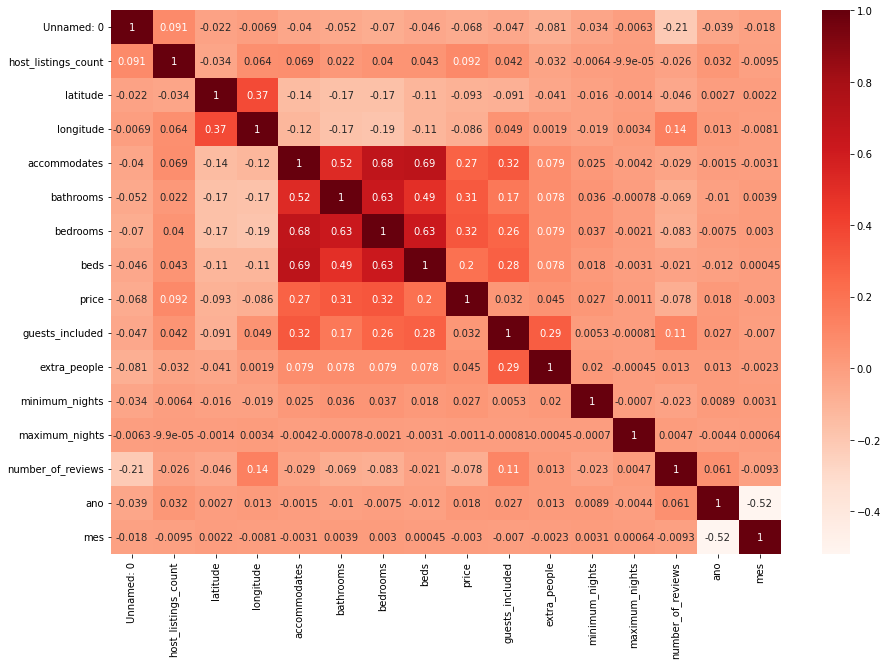

In [37]:
# Definir tamanho do gráfico
plt.figure(figsize=(15,10))

# Plotagem
sns.heatmap(base_airbnb_final.corr(), annot=True, cmap='Reds')


### Definição de função para determinar os limites (Análise de Outliers)

In [39]:
def limite(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [40]:
print(limite(base_airbnb_final['price']))
print(limite(base_airbnb_final['bedrooms']))
print(limite(base_airbnb_final['bathrooms']))

(-524.0, 1276.0)
(-0.5, 3.5)
(-0.5, 3.5)


In [41]:
print(base_airbnb_final['price'].describe())
# Mesma coisa que:
print('*'*60)
print(151 - 1.5 * (601-151),601 + 1.5 * (601-151))

count    902210.000000
mean        647.605448
std        1704.745062
min           0.000000
25%         151.000000
50%         296.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64
************************************************************
-524.0 1276.0


In [98]:
def diagrama_caixa(coluna):
    # Plotagem de gráfico 1 linha x 2 colunas
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    
    sns.boxplot(x=coluna, ax=ax1)
    
    ax2.set_xlim(limite(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna, xlim = None, ylim = None):
    plt.figure(figsize=(25,5))
    sns.histplot(x=coluna, bins = 50, kde=True)
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if ylim is not None:
        plt.ylim(ylim)
        
def excluir_outliers(df, nome_coluna):
    # shape retorna uma tupla (linhas, coluna)
    qtd_linhas = df.shape[0]
    
    #limites() retorna uma tupla(limite inferior da coluna, superior da coluna)
    lim_inf, lim_sup = limites(df[nome_coluna])
    
    # extrai as linhas que atende a condição e todas as colunas
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    
    

# Price


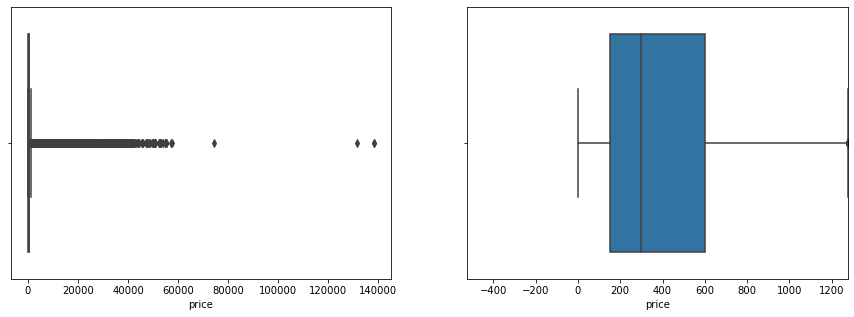

In [48]:
diagrama_caixa(base_airbnb_final['price'])

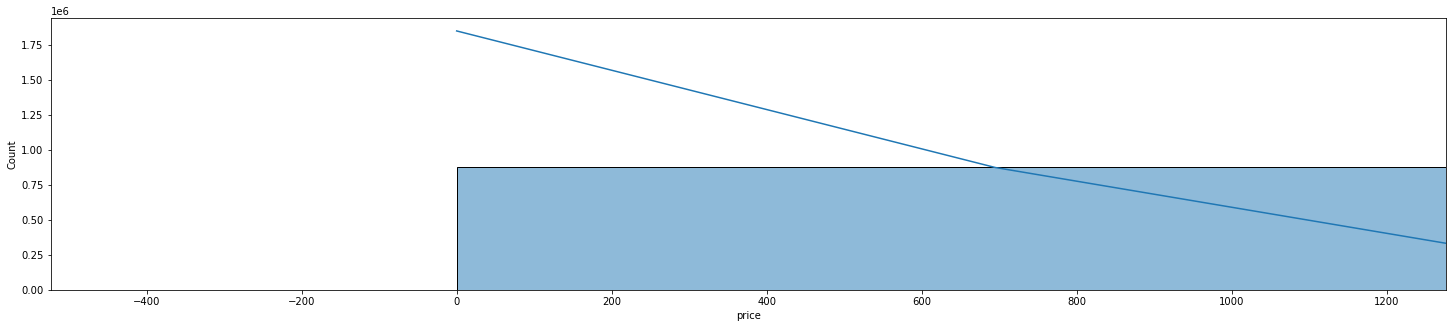

In [99]:
histograma(base_airbnb_final['price'], xlim=limite(base_airbnb_final['price']))

In [88]:
limite(base_airbnb_final['price'])

(-524.0, 1276.0)